Data will be fetched from 2023-05-08 to 2025-05-07
Fetching data for ^GSPC from 2023-05-08 to 2025-05-07...
YF.download() has changed argument auto_adjust default to True


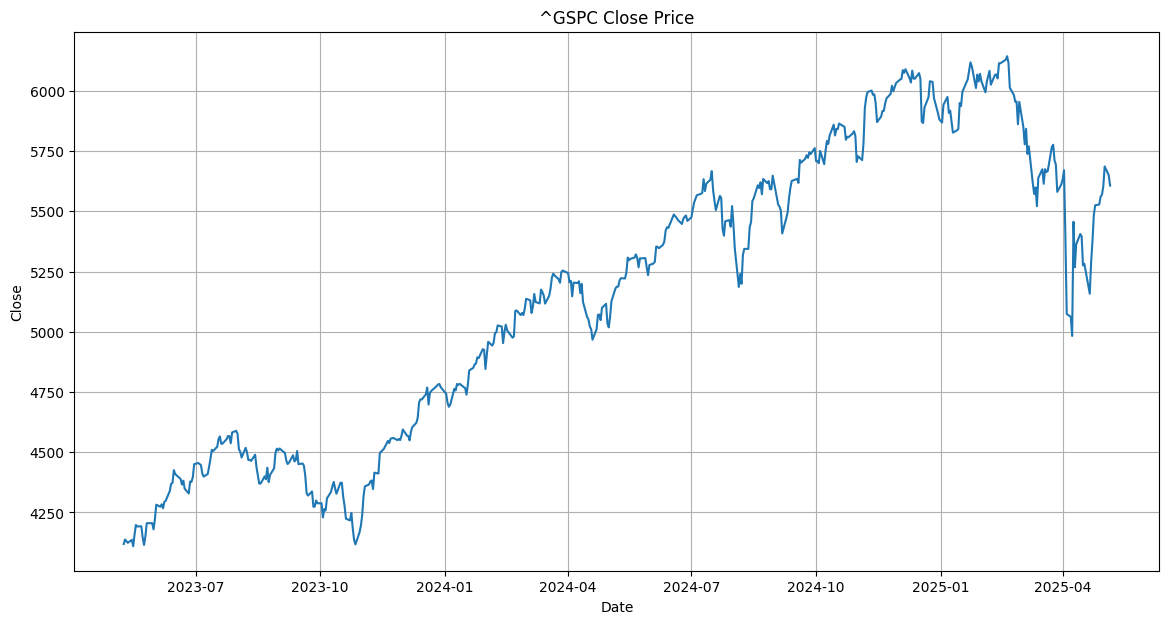

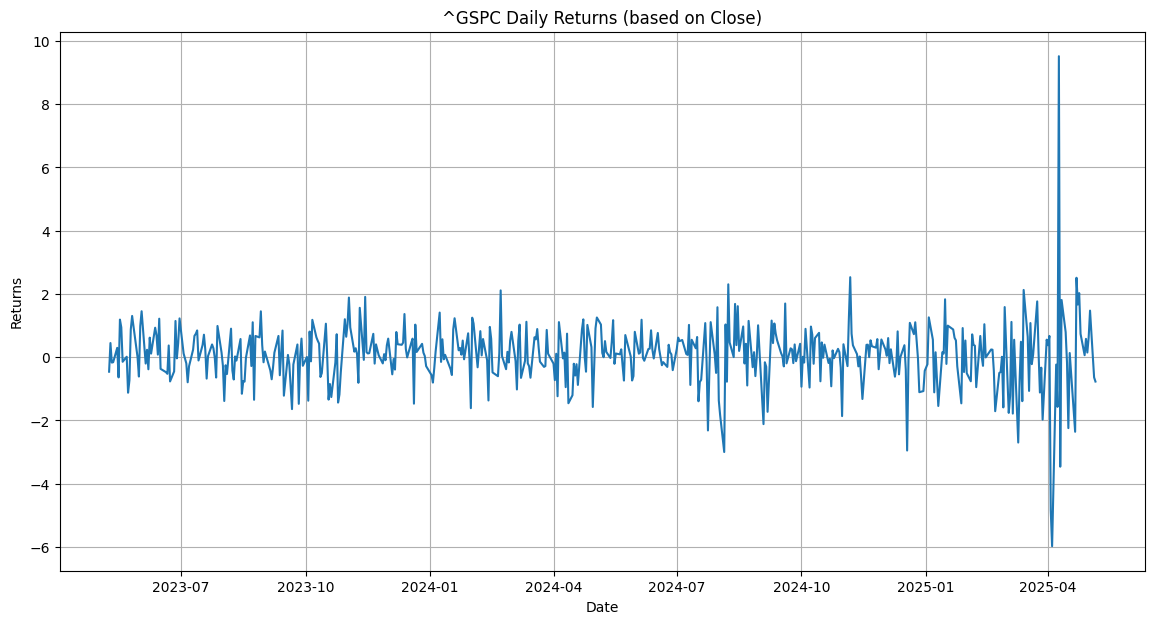


ADF Statistic (Train Returns): -19.0876
p-value (Train Returns): 0.0000
=> Returns are likely stationary (reject H0)

Training data length: 400
Test data length: 100

--- ARIMA Model ---
Finding optimal ARIMA parameters using auto_arima...
Auto ARIMA optimal order: (0, 0, 0)
Using ARIMA(0,0,0) for rolling forecast...
ARIMA - Test Set Evaluation (on 100 points):
  MSE: 2.7792
  RMSE: 1.6671
  MAE: 1.0575

--- GARCH Model (Volatility) ---
Fitting GARCH(1,1) model...

--- Hidden Markov Model ---
Fitting HMM with 2 states...
HMM (Regime Mean) - Test Set Evaluation (on 100 points):
  MSE: 2.8310
  RMSE: 1.6826
  MAE: 1.0622

--- LSTM Model ---
Building LSTM model...
Training LSTM model...
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - loss: 0.1384 - val_loss: 0.0508
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0452 - val_loss: 0.0308
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0322 - val_loss: 0.0193
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/ste

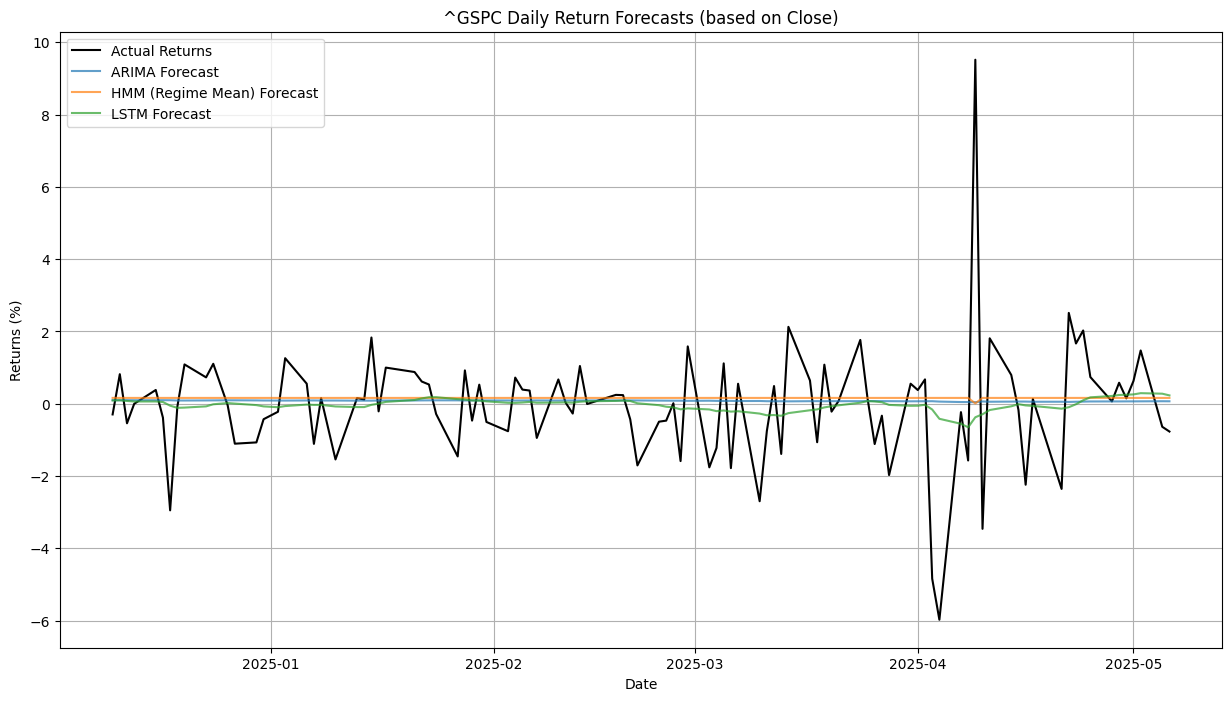

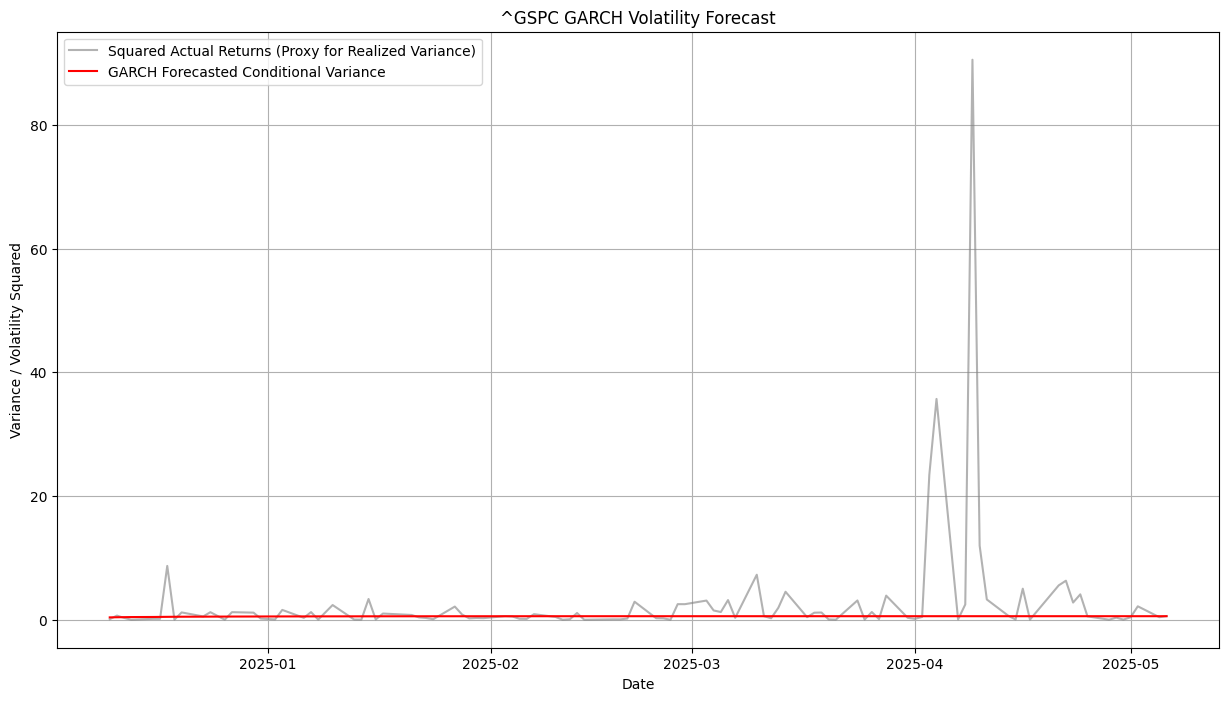

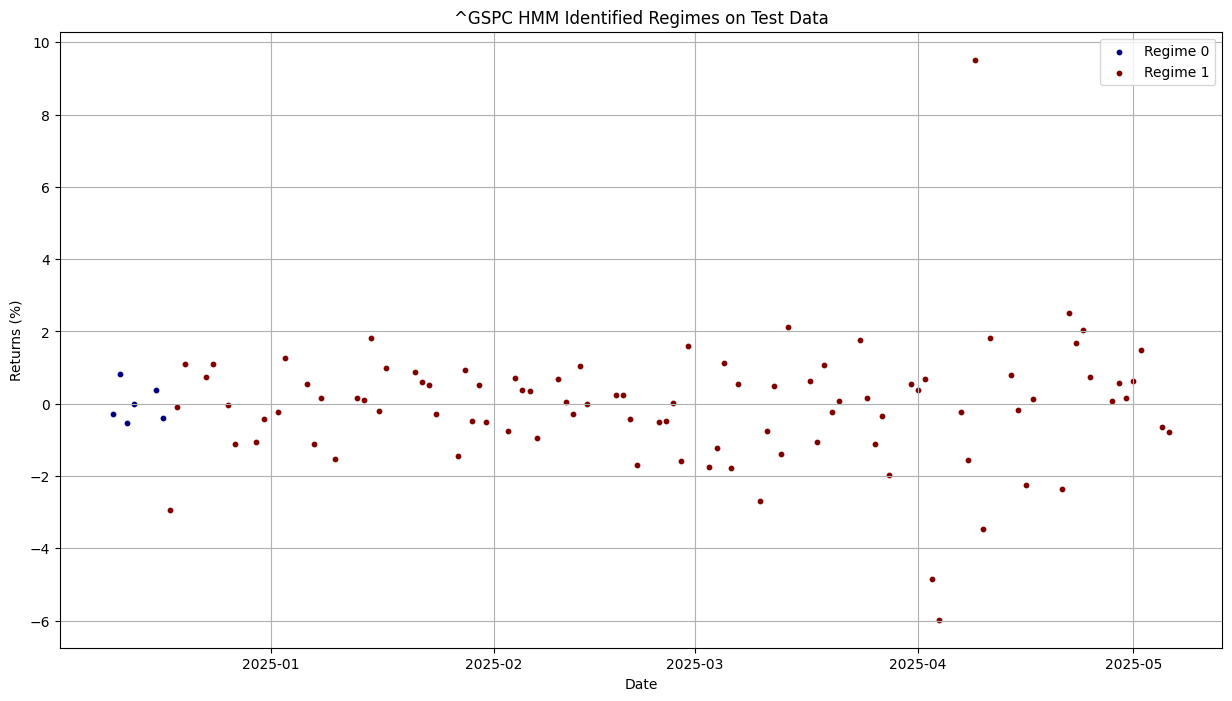


Project execution finished.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from hmmlearn import hmm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pmdarima as pm # For auto_arima

# Import for date calculations
from datetime import datetime, timedelta

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings("ignore")

# --- Configuration ---
TICKER = '^GSPC'  # Example: S&P 500

# Calculate dynamic dates for the last 2 years
TODAY = datetime.today()
END_DATE = TODAY.strftime('%Y-%m-%d')
START_DATE_DATETIME = TODAY - timedelta(days=2*365) # Approximate 2 years
START_DATE = START_DATE_DATETIME.strftime('%Y-%m-%d')

print(f"Data will be fetched from {START_DATE} to {END_DATE}")

TRAIN_SPLIT_RATIO = 0.8
LSTM_LOOK_BACK = 60
LSTM_EPOCHS = 30
LSTM_BATCH_SIZE = 32

# --- 1. Data Acquisition & Preprocessing ---
def get_data(ticker, start, end):
    print(f"Fetching data for {ticker} from {start} to {end}...")
    df = yf.download(ticker, start=start, end=end, progress=False)
    if df.empty:
        print(f"No data found for {ticker} from {start} to {end}.")
        return pd.DataFrame()

    # Use 'Close' price instead of 'Adj Close'
    if 'Close' not in df.columns:
        print(f"'Close' column not found in data for {ticker}. Available columns: {df.columns.tolist()}")
        return pd.DataFrame()

    df['Returns'] = df['Close'].pct_change() * 100 # Percentage returns based on 'Close'
    df.dropna(inplace=True)
    return df

def plot_time_series(df, column='Close', title='Time Series Plot'): # Default column changed for clarity
    if df.empty or column not in df.columns:
        print(f"Cannot plot time series: DataFrame is empty or column '{column}' not found.")
        return
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[column])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

# --- 2. ARIMA Model ---
def arima_forecasting(train_data, test_data):
    print("\n--- ARIMA Model ---")
    if train_data.empty or test_data.empty:
        print("ARIMA: Train or test data is empty. Skipping.")
        return pd.Series(index=test_data.index)

    history = [x for x in train_data]
    predictions = []

    print("Finding optimal ARIMA parameters using auto_arima...")
    try:
        auto_model = pm.auto_arima(train_data,
                                   start_p=1, start_q=1,
                                   test='adf',
                                   max_p=3, max_q=3, m=1,
                                   d=None, seasonal=False,
                                   start_P=0, D=0, trace=False,
                                   error_action='ignore',
                                   suppress_warnings=True,
                                   stepwise=True)
        print(f"Auto ARIMA optimal order: {auto_model.order}")
        p, d, q = auto_model.order
    except Exception as e:
        print(f"auto_arima failed: {e}. Using default order (1,0,1).")
        p, d, q = 1, 0, 1

    print(f"Using ARIMA({p},{d},{q}) for rolling forecast...")
    for t in range(len(test_data)):
        try:
            model = ARIMA(history, order=(p, d, q))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test_data[t]
            history.append(obs)
        except Exception as e:
            # print(f"Error during ARIMA forecast step {t+1}/{len(test_data)}: {e}") # Optional detailed error
            predictions.append(np.nan)
            if t < len(test_data):
                history.append(test_data[t])

    while len(predictions) < len(test_data):
        predictions.append(np.nan)
    return pd.Series(predictions, index=test_data.index)

# --- 3. GARCH Model (Volatility Forecasting) ---
def garch_volatility_forecasting(train_data, test_data):
    print("\n--- GARCH Model (Volatility) ---")
    if train_data.empty or test_data.empty:
        print("GARCH: Train or test data is empty. Skipping.")
        return pd.Series(index=test_data.index)

    print("Fitting GARCH(1,1) model...")
    try:
        garch_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant', rescale=False)
        garch_fit = garch_model.fit(disp='off', last_obs=train_data.index[-1] if not train_data.empty else None)
        forecasts = garch_fit.forecast(horizon=len(test_data), reindex=False)
        vol_predictions = np.sqrt(forecasts.variance.iloc[0,:].values)
        if len(vol_predictions) > len(test_data):
            vol_predictions = vol_predictions[:len(test_data)]
        elif len(vol_predictions) < len(test_data):
            vol_predictions = np.pad(vol_predictions, (0, len(test_data) - len(vol_predictions)), 'constant', constant_values=np.nan)
    except Exception as e:
        print(f"GARCH model fitting or forecasting failed: {e}")
        vol_predictions = [np.nan] * len(test_data)
    return pd.Series(vol_predictions, index=test_data.index)

# --- 4. Hidden Markov Model (Regime Switching) ---
def hmm_regime_and_forecasting(train_data, test_data, n_states=2):
    print("\n--- Hidden Markov Model ---")
    if train_data.empty or test_data.empty:
        print("HMM: Train or test data is empty. Skipping.")
        return pd.Series(index=test_data.index), np.array([])

    hmm_train_data = train_data.values.reshape(-1, 1)
    hmm_test_data = test_data.values.reshape(-1, 1)

    print(f"Fitting HMM with {n_states} states...")
    try:
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42,
                                params="stmc", init_params="stmc")
        model.fit(hmm_train_data)
        test_regimes = model.predict(hmm_test_data)
        hmm_predictions = []
        for i in range(len(hmm_test_data)):
            current_regime = model.predict(hmm_test_data[i].reshape(1,-1))[0]
            hmm_predictions.append(model.means_[current_regime,0])
    except Exception as e:
        print(f"HMM model fitting or prediction failed: {e}")
        test_regimes = np.array([np.nan] * len(hmm_test_data))
        hmm_predictions = [np.nan] * len(hmm_test_data)
    return pd.Series(hmm_predictions, index=test_data.index), test_regimes

# --- 5. LSTM Model ---
def create_lstm_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def lstm_forecasting(train_data, test_data, look_back=LSTM_LOOK_BACK):
    print("\n--- LSTM Model ---")
    if train_data.empty or test_data.empty or len(train_data) <= look_back or len(test_data) <= look_back:
        print("LSTM: Not enough data for training or testing with the given look_back. Skipping.")
        return pd.Series(index=test_data.index)

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.values.reshape(-1, 1))
    trainX, trainY = create_lstm_dataset(train_scaled, look_back)

    if trainX.shape[0] == 0:
        print("LSTM: Not enough training data to form sequences. Skipping.")
        return pd.Series(index=test_data.index)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    print("Building LSTM model...")
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    print("Training LSTM model...")
    try:
        model.fit(trainX, trainY, epochs=LSTM_EPOCHS, batch_size=LSTM_BATCH_SIZE,
                  validation_split=0.1, callbacks=[early_stopping], verbose=1)
    except Exception as e:
        print(f"LSTM training failed: {e}")
        return pd.Series(index=test_data.index[look_back-1:] if len(test_data) >= look_back else test_data.index) # Adjust index for return

    print("Forecasting with LSTM (walk-forward on test set)...")
    lstm_predictions_scaled = []
    current_batch_scaled = train_scaled[-look_back:]
    current_batch_reshaped = current_batch_scaled.reshape(1, look_back, 1)

    for i in range(len(test_scaled)):
        pred_scaled = model.predict(current_batch_reshaped, verbose=0)[0]
        lstm_predictions_scaled.append(pred_scaled[0])
        if i < len(test_scaled) -1:
            next_actual_obs_scaled = test_scaled[i+1].reshape(1,1,1)
            current_batch_reshaped = np.append(current_batch_reshaped[:,1:,:], next_actual_obs_scaled, axis=1)

    lstm_predictions_scaled_array = np.array(lstm_predictions_scaled).reshape(-1,1)
    lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled_array).flatten()
    return pd.Series(lstm_predictions, index=test_data.index[:len(lstm_predictions)])

# --- 6. Evaluation ---
def evaluate_forecast(actual, predicted, model_name="Model"):
    if predicted is None or predicted.empty:
        #print(f"Cannot evaluate {model_name}: No predictions provided.")
        return None, None, None
    predicted_clean = predicted.dropna()
    if predicted_clean.empty:
        #print(f"Cannot evaluate {model_name}: All predictions are NaN.")
        return None, None, None
    actual_aligned = actual.reindex(predicted_clean.index).dropna()
    common_index = actual_aligned.index.intersection(predicted_clean.index)
    if common_index.empty:
        #print(f"Cannot evaluate {model_name}: No common data points.")
        return None, None, None
    actual_final = actual_aligned.loc[common_index]
    predicted_final = predicted_clean.loc[common_index]
    if len(actual_final) == 0:
        #print(f"Cannot evaluate {model_name}: No data left after aligning.")
        return None, None, None
    mse = mean_squared_error(actual_final, predicted_final)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_final, predicted_final)
    print(f"{model_name} - Test Set Evaluation (on {len(actual_final)} points):")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    return mse, rmse, mae

# --- 7. Visualization ---
def plot_return_forecasts(actual, forecasts_dict, title="Return Forecasts vs Actual"):
    if actual.empty:
        print("Cannot plot return forecasts: Actual data is empty.")
        return
    plt.figure(figsize=(15, 8))
    plt.plot(actual.index, actual, label='Actual Returns', color='black', linewidth=1.5)
    for model_name, forecast in forecasts_dict.items():
        if forecast is not None and not forecast.empty:
            if isinstance(actual.index, pd.DatetimeIndex) and not isinstance(forecast.index, pd.DatetimeIndex):
                try: forecast.index = pd.to_datetime(forecast.index)
                except: continue
            common_idx = actual.index.intersection(forecast.index)
            if not common_idx.empty:
                 plt.plot(common_idx, forecast.loc[common_idx], label=f'{model_name} Forecast', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_garch_volatility(actual_returns, garch_vol_forecast, title="GARCH Volatility Forecast"):
    if actual_returns.empty or (garch_vol_forecast is None or garch_vol_forecast.empty):
        print("Cannot plot GARCH volatility: Data is missing.")
        return
    plt.figure(figsize=(15, 8))
    realized_vol_proxy = actual_returns**2
    plt.plot(realized_vol_proxy.index, realized_vol_proxy, label='Squared Actual Returns (Proxy for Realized Variance)', color='grey', alpha=0.6)
    common_idx = realized_vol_proxy.index.intersection(garch_vol_forecast.index)
    if not common_idx.empty:
        plt.plot(common_idx, garch_vol_forecast.loc[common_idx]**2, label='GARCH Forecasted Conditional Variance', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Variance / Volatility Squared')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_hmm_regimes(returns_on_test, regimes, title="HMM Identified Regimes on Test Data"):
    if returns_on_test.empty or regimes is None or len(regimes) == 0 or np.all(np.isnan(regimes)):
        print("Cannot plot HMM regimes: Data or regimes are missing/invalid.")
        return
    plt.figure(figsize=(15, 8))
    min_len = min(len(regimes), len(returns_on_test))
    regimes_plot = regimes[:min_len]
    returns_to_plot = returns_on_test.iloc[:min_len]
    valid_regimes_mask = ~np.isnan(regimes_plot)
    if not np.any(valid_regimes_mask):
        print("All HMM regimes are NaN after alignment. Skipping plot.")
        return
    unique_regimes = np.unique(regimes_plot[valid_regimes_mask])
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_regimes)))
    for i, regime_val in enumerate(unique_regimes):
        mask = (regimes_plot == regime_val) & valid_regimes_mask
        if np.any(mask):
            plt.scatter(returns_to_plot.index[mask], returns_to_plot.values[mask],
                        color=colors[i], label=f'Regime {int(regime_val)}', s=10)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Get Data
    data_df = get_data(TICKER, START_DATE, END_DATE)

    if data_df.empty:
        print("Exiting: No data loaded.")
    else:
        # Plot 'Close' price as it's now the basis for returns
        plot_time_series(data_df, 'Close', f'{TICKER} Close Price')
        plot_time_series(data_df, 'Returns', f'{TICKER} Daily Returns (based on Close)')

        returns = data_df['Returns']
        split_idx = int(len(returns) * TRAIN_SPLIT_RATIO)
        train_returns_for_adf = returns[:split_idx]

        if not train_returns_for_adf.empty:
            adf_result = adfuller(train_returns_for_adf.dropna())
            print(f'\nADF Statistic (Train Returns): {adf_result[0]:.4f}')
            print(f'p-value (Train Returns): {adf_result[1]:.4f}')
            if adf_result[1] <= 0.05: print("=> Returns are likely stationary (reject H0)")
            else: print("=> Returns are likely non-stationary (fail to reject H0)")
        else: print("Not enough training data for ADF test.")

        train_returns = returns[:split_idx]
        test_returns = returns[split_idx:]
        print(f"\nTraining data length: {len(train_returns)}")
        print(f"Test data length: {len(test_returns)}")

        all_forecasts = {}
        evaluation_results = {}

        # 2. ARIMA
        if not train_returns.empty and not test_returns.empty:
            try:
                arima_preds = arima_forecasting(train_returns.copy(), test_returns.copy())
                all_forecasts['ARIMA'] = arima_preds
                mse, rmse, mae = evaluate_forecast(test_returns, arima_preds, "ARIMA")
                if mse is not None: evaluation_results['ARIMA'] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
            except Exception as e: print(f"ARIMA process failed: {e}"); all_forecasts['ARIMA'] = pd.Series(index=test_returns.index)
        else: print("Skipping ARIMA due to empty train/test data."); all_forecasts['ARIMA'] = pd.Series(index=test_returns.index)

        # 3. GARCH
        garch_vol_preds = None
        if not train_returns.empty and not test_returns.empty:
            try:
                garch_vol_preds = garch_volatility_forecasting(train_returns.copy(), test_returns.copy())
            except Exception as e: print(f"GARCH process failed: {e}"); garch_vol_preds = pd.Series(index=test_returns.index)
        else: print("Skipping GARCH due to empty train/test data."); garch_vol_preds = pd.Series(index=test_returns.index)

        # 4. HMM
        hmm_test_regimes = np.array([])
        if not train_returns.empty and not test_returns.empty:
            try:
                n_hmm_states = 2
                hmm_preds, hmm_test_regimes = hmm_regime_and_forecasting(train_returns.copy(), test_returns.copy(), n_states=n_hmm_states)
                all_forecasts['HMM (Regime Mean)'] = hmm_preds
                mse_hmm, rmse_hmm, mae_hmm = evaluate_forecast(test_returns, hmm_preds, "HMM (Regime Mean)")
                if mse_hmm is not None: evaluation_results['HMM (Regime Mean)'] = {'MSE': mse_hmm, 'RMSE': rmse_hmm, 'MAE': mae_hmm}
            except Exception as e: print(f"HMM process failed: {e}"); all_forecasts['HMM (Regime Mean)'] = pd.Series(index=test_returns.index)
        else: print("Skipping HMM due to empty train/test data."); all_forecasts['HMM (Regime Mean)'] = pd.Series(index=test_returns.index)

        # 5. LSTM
        if not train_returns.empty and not test_returns.empty:
            try:
                lstm_preds = lstm_forecasting(train_returns.copy(), test_returns.copy(), look_back=LSTM_LOOK_BACK)
                all_forecasts['LSTM'] = lstm_preds
                mse_lstm, rmse_lstm, mae_lstm = evaluate_forecast(test_returns, lstm_preds, "LSTM")
                if mse_lstm is not None: evaluation_results['LSTM'] = {'MSE': mse_lstm, 'RMSE': rmse_lstm, 'MAE': mae_lstm}
            except Exception as e: print(f"LSTM process failed: {e}"); all_forecasts['LSTM'] = pd.Series(index=test_returns.index)
        else: print("Skipping LSTM due to empty train/test data."); all_forecasts['LSTM'] = pd.Series(index=test_returns.index)

        print("\n--- Overall Model Evaluation Summary ---")
        eval_df = pd.DataFrame(evaluation_results).T
        if not eval_df.empty: print(eval_df)
        else: print("No models were successfully evaluated or evaluation data was insufficient.")

        plot_return_forecasts(test_returns, all_forecasts, title=f'{TICKER} Daily Return Forecasts (based on Close)')
        if garch_vol_preds is not None and not garch_vol_preds.empty:
            plot_garch_volatility(test_returns, garch_vol_preds, title=f'{TICKER} GARCH Volatility Forecast')
        else: print("Skipping GARCH plot as predictions are unavailable or empty.")
        if len(hmm_test_regimes) > 0 and not test_returns.empty:
            plot_hmm_regimes(test_returns, hmm_test_regimes, title=f'{TICKER} HMM Identified Regimes on Test Data')
        else: print("Skipping HMM regime plot as regimes or test returns are unavailable/empty.")
        print("\nProject execution finished.")